In [1]:
# first check the wd
# this should be AIggregation folder, change if its not

import os

print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


cwd is /home/tmueller/github/AIggregation/notebooks
cwd changed to /home/tmueller/github/AIggregation


 100% |█████████████████████| 1/1 [23.3ms elapsed, 0s remaining, 49.9 samples/s] 



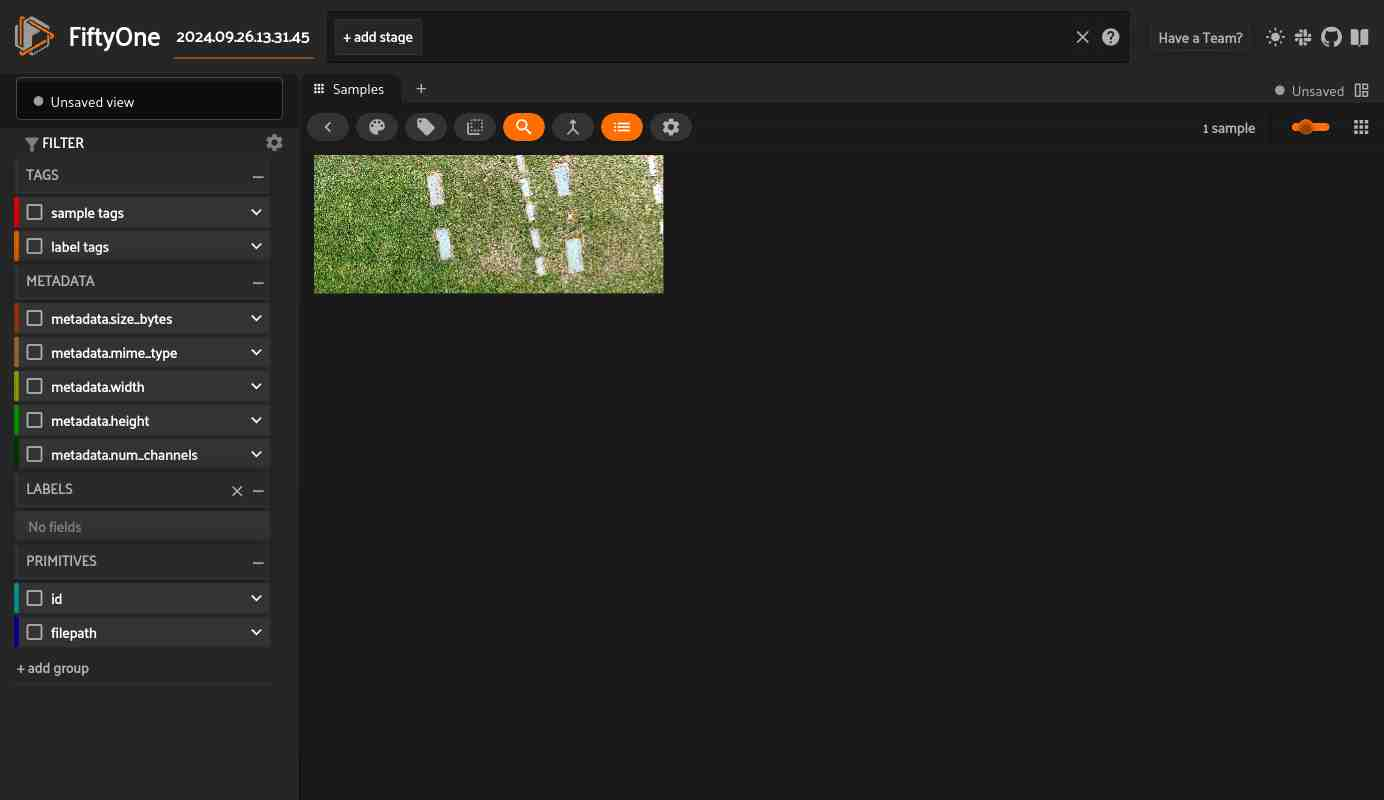

In [2]:
# import fiftyone
import fiftyone as fo

# Import ortho image into fiftyone dataset type
dataset = fo.Dataset.from_images(
    ["datasets/drone_ortho/ortho_clip_23april.png"]
)


# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)

 100% |█████████████████████| 1/1 [26.5m elapsed, 0s remaining, 0.0 samples/s] 


09/26/2024 13:58:41 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [26.5m elapsed, 0s remaining, 0.0 samples/s] 



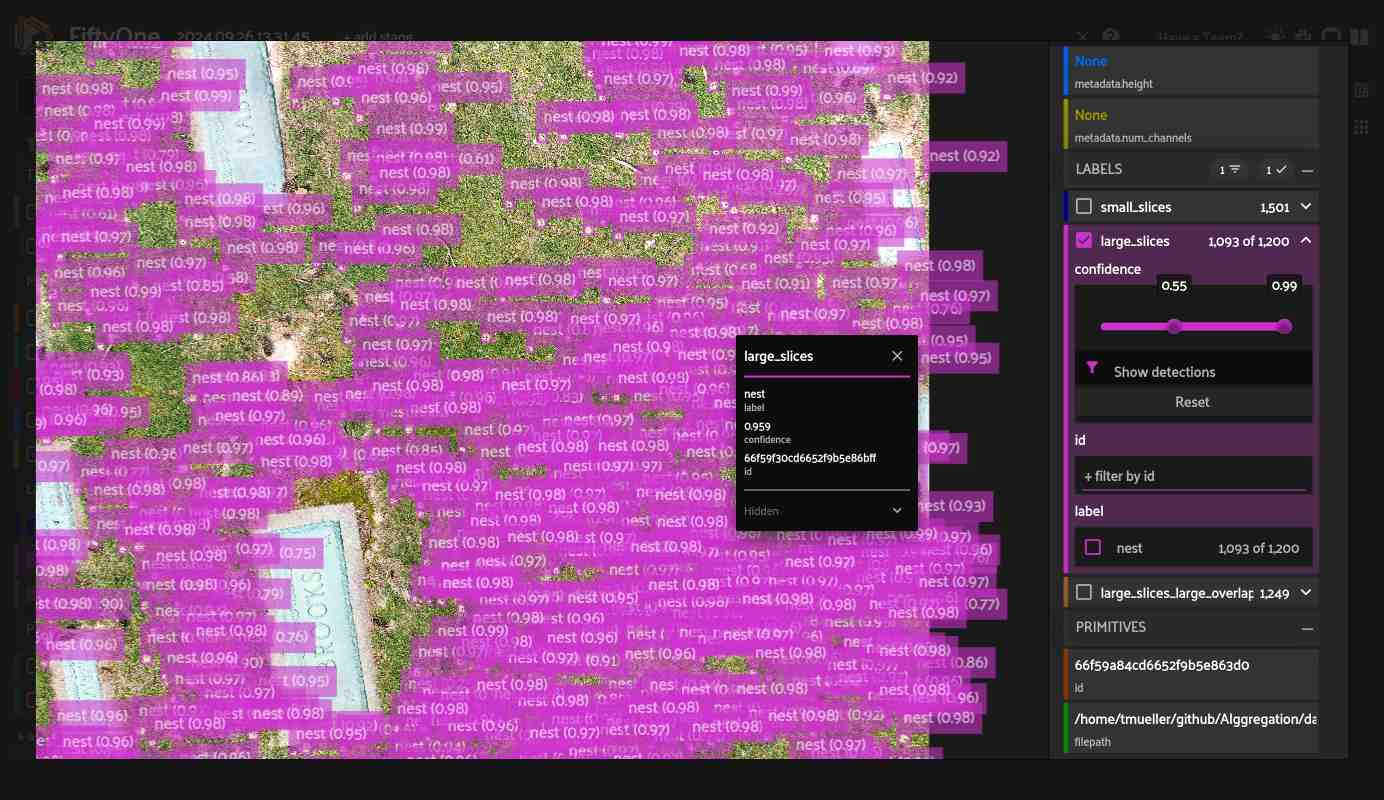

In [3]:
# import sahi 
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction


# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)

# Run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample,
                         label_field="small_slices",
                         slice_height=304,
                         slice_width=304,overlap_height_ratio = .2,
                         overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .2, overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices_large_overlap",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .4, overlap_width_ratio=.4,
                         **kwargs
    )


#bring up new session to see boxes
session.show()

# this might take several minutes. took 26 minutes on my computer (12 threads)


In [14]:
# export the 3 different sahi predictions and save them



# first specify directories and which bounding boxes (labels) to export to each dir
# this will create those dir but fail if they already exist

small_dir = "datasets/export_predictions/small_slices"
small_label = "small_slices"  

large_dir = "datasets/export_predictions/large_slices"
large_label = "large_slices"  

largelarge_dir = "datasets/export_predictions/large_slices_large_overlap"
largelarge_label = "large_slices_large_overlap"  


#export small slice
dataset.export(
        export_dir=small_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=small_label,
        include_confidence=True
    )

#export large slice
dataset.export(
        export_dir=large_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=large_label,
        include_confidence=True
    )


#export large slice large overlap
dataset.export(
        export_dir=largelarge_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=largelarge_label,
        include_confidence=True
    )





 100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


09/24/2024 13:35:27 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 


09/24/2024 13:35:28 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 


 100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


09/24/2024 13:35:29 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


In [15]:
# rearrange files to all be together before tiling

import shutil


# create a loop that goes through the 3 folders
directory = "datasets/export_predictions/"

filelist = []

# walk through folders and make a copy of JPGS and txt up 2 directories
for root, dirs, files in os.walk(directory):
    for file in files:
        filelist.append(os.path.join(root,file))
        for jpgtxtFile in filelist:
            if jpgtxtFile.endswith((".JPG", ".png", ".txt")):
                shutil.copy(jpgtxtFile, "/".join(list(jpgtxtFile.split('/')[0:-3])) )  # this splits the jpg/png/txt path at "/"" and drops the last 3 parts (moving it up 2 dir)




In [36]:



# tile the image and outputs


''' 
the exported sahi prediction can now be tiled. 

The below script takes a folder containing identically named image and txt files and tiles them into a new folder. 
This was written for yolov4 format which is slightly different but works for this itll just warn of no Class file and output all files into a single folder

'''

# but first set max image to your image size
# otherwise python thinks its a bomb DOS attack if its too large

from PIL import Image
Image.MAX_IMAGE_PIXELS = 349501440



# run yolo_tile script
%run scripts/yolo_tile_conf.py -source ./datasets/export_predictions/large_slices -target ./datasets/tiled_export/tiles/large_slices -ext .png -falsefolder ./datasets/tiled_export/tiles/large_slices -size 608 -ratio 0.8
%run scripts/yolo_tile_conf.py -source ./datasets/export_predictions/small_slices -target ./datasets/tiled_export/tiles/small_slices -ext .png -falsefolder ./datasets/tiled_export/tiles/small_slices -size 608 -ratio 0.8
%run scripts/yolo_tile_conf.py -source ./datasets/export_predictions/large_slices_large_overlap -target ./datasets/tiled_export/tiles/large_slices_large_overlap -ext .png -falsefolder ./datasets/tiled_export/tiles/large_slices_large_overlap -size 608 -ratio 0.8



# the ratio creates txt files listing a random list of the tiles  in each set (test/train)

'''
    PARAMETERS:

    -source         Source folder with images and labels needed to be tiled. Default: ./yolosample/ts/
    -target         Target folder for a new sliced dataset. Default: ./yolosliced/ts/
    -ext            Image extension in a dataset. Default: .JPG
    -falsefolder    Folder for tiles without bounding boxes
    -size           Size of a tile. Default: 416
    -ratio          Train/test split ratio. Dafault: 0.8 (i.e. 80% in train)
'''


# write a yaml file for each folder

import yaml

directory = "datasets/tiled_export/tiles/"

filelist = []

folder = ["large_slices_large_overlap", "large_slices", "small_slices"]


for f in folder:
    data = {
        'names':{
        0: "nest"},
        'path': os.path.join("..", f),
        'val': "./images/"
            }
    with open((os.path.join(directory, f,"data.yaml")), 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)



# create new images and labels folders
import os
names = ("images","labels")
pathlist = []


for f in folder:
    path= os.path.join(directory,f)
    pathlist.append(os.path.join(path))


for name in names:
    for p in pathlist:
        newpath = (os.path.join(p, name))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
            print("folder created:", newpath)




classes.names not found. It should be located one level higher than images
Image: ./datasets/export_predictions/large_slices/ortho_clip_23april.png
[(0, <POLYGON ((18918.849 11261.86, 19027.88 11261.86, 19027.88 11380.522, 18918....>, 0.987568), (0, <POLYGON ((19770.219 9266.431, 19891.946 9266.431, 19891.946 9383.233, 19770...>, 0.986684), (0, <POLYGON ((18955.781 8929.136, 19066.885 8929.136, 19066.885 9041.987, 18955...>, 0.986573), (0, <POLYGON ((25237.637 734.511, 25362.399 734.511, 25362.399 856.685, 25237.63...>, 0.986506), (0, <POLYGON ((28346.551 3938.418, 28452.634 3938.418, 28452.634 4050.83, 28346....>, 0.986438), (0, <POLYGON ((25404.774 10602.957, 25533.913 10602.957, 25533.913 10717.091, 25...>, 0.986427), (0, <POLYGON ((16236.475 8288.687, 16348.804 8288.687, 16348.804 8396.167, 16236...>, 0.986159), (0, <POLYGON ((22388.783 8869.562, 22525.743 8869.562, 22525.743 8983.569, 22388...>, 0.98601), (0, <POLYGON ((25129.16 9941.137, 25235.77 9941.137, 25235.77 10046.526, 251

In [37]:

# copies txt and image files that are in the testlist.txt file back into yolo5 format (into image and label folders)

import os 
import shutil


# I need to drop root from file names in testlist before writing to csv

directory = "datasets/tiled_export/tiles"
folder = ["large_slices_large_overlap", "large_slices", "small_slices"]

testpath = 'datasets/tiled_export/tiles/test.txt'
testwritepath = 'datasets/groundtruth_testset/testlist.txt'

testfilelist=[]
testlist =[]

# open file and read into list
with open(testpath, 'r') as fp:
    tlist = fp.read().splitlines()

# double strings to add the same list of txt
tlist.extend([w.replace('png', 'txt') for w in tlist])

# drop the root portion and only retain file names - we'll add these back for each folder later
for file in tlist:
    testfilelist.append(os.path.basename(file))

# write this to the groundtruth folder unless it already exists
if not os.path.exists(testwritepath):
    with open(testwritepath, "w") as output:
        for line in testfilelist:
            output.write(f"{line}\n")




# open testlist.txt
with open(testwritepath, 'r') as fp:
    testlist = fp.read().splitlines()


#and move files listed in testlist.txt to corresponding folders. These are the test dataset and should mirror the annotated test dataset (ground truth)


for f in folder:
    for item in testlist:
            if item.endswith(".png") and os.path.exists(os.path.join(directory,f, item)):
                shutil.copy(os.path.join(directory,f, item), os.path.join(directory,f, "images"))
            elif item.endswith(".txt") and os.path.exists(os.path.join(directory,f, item)):
                shutil.copy(os.path.join(directory,f, item), os.path.join(directory,f, "labels"))
    
# use the above created image files to annotate a ground truth dataset in label studio
# label studio currently gets grumpy if you put over 100 images into a single  folder. you can fix this by changing
# "DATA_UPLOAD_MAX_NUMBER_FILES =" to "None" in label-studio/label_studio/core/settings/base.py

 100% |█████████████████| 102/102 [176.2ms elapsed, 0s remaining, 578.7 samples/s]     
 100% |███████████████████| 95/95 [123.1ms elapsed, 0s remaining, 780.7 samples/s] 
 100% |█████████████████| 100/100 [129.4ms elapsed, 0s remaining, 781.1 samples/s] 
 100% |█████████████████| 165/165 [139.3ms elapsed, 0s remaining, 1.2K samples/s]  
Indexing dataset...
 100% |███████████████████| 95/95 [48.6ms elapsed, 0s remaining, 2.0K samples/s] 
Merging samples...
 100 [268.6ms elapsed, ? remaining, 372.4 samples/s] 
Indexing dataset...
 100% |█████████████████| 102/102 [54.8ms elapsed, 0s remaining, 1.9K samples/s] 
Merging samples...
 102 [378.4ms elapsed, ? remaining, 270.5 samples/s] 
Indexing dataset...
 100% |█████████████████| 111/111 [146.6ms elapsed, 0s remaining, 756.9 samples/s]     
Merging samples...
 165 [490.7ms elapsed, ? remaining, 336.3 samples/s] 



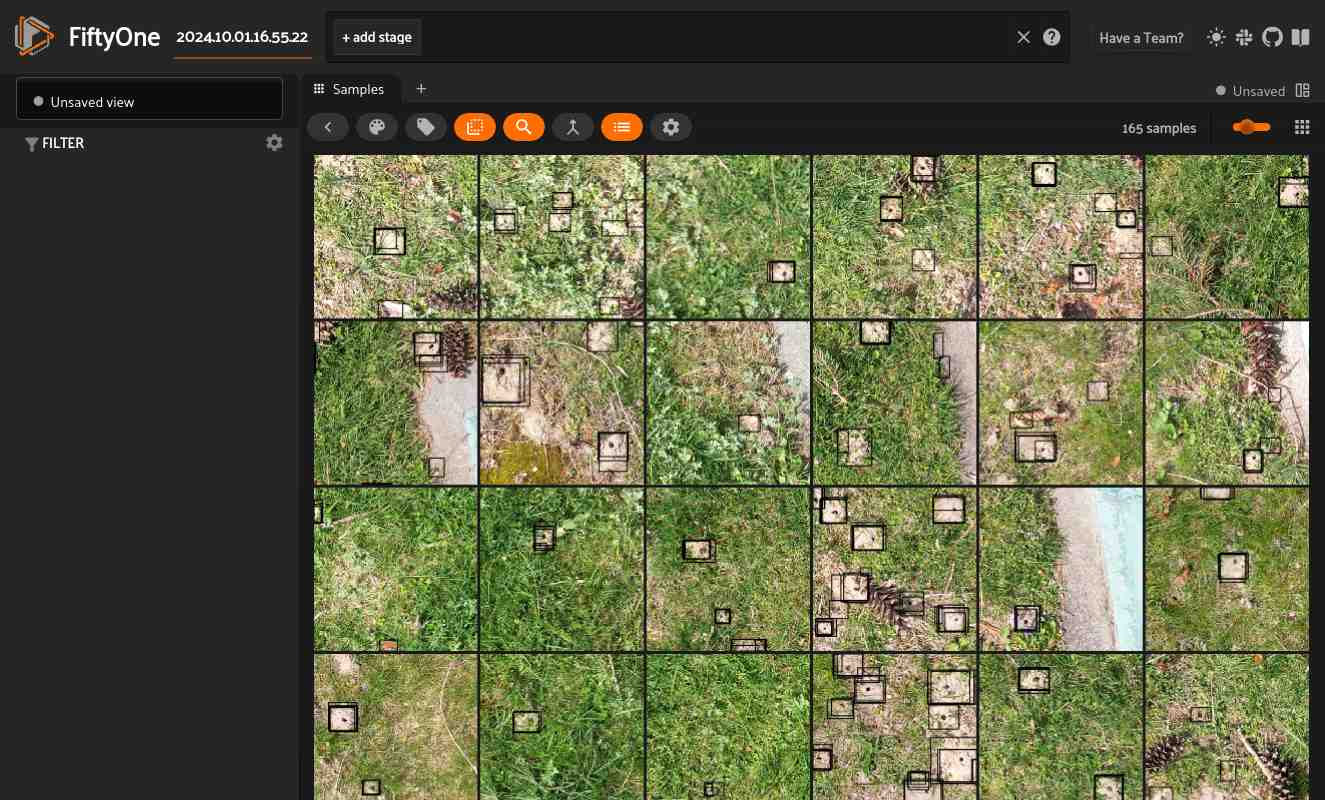

In [150]:
'''
reimport as individual fiftyone files

then merge files with different labels

THERE IS A MINI SCRIPT IN PREPROSSESSING THAT RENAMES THE LABELSTUDIO EXPORTS TO BE A CONSISTANT FILE NAME


'''

import fiftyone as fo

#then import in fiftyone


# Import annotated datasets by labels
datasettest = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/small_slices/data.yaml",
    label_field= "small_slices"
)


datasettest2 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/large_slices/data.yaml",
    label_field= "large_slices"
)

datasettest3 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/large_slices_large_overlap/data.yaml",
    label_field= "large_slices_large_overlap"
)


dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/groundtruth_testset/data.yaml",
    label_field= "ground_truth"
)



# now merge the datasets, ignoring that they have different directory and merging images/labels with the same file name

key_fcn = lambda sample: os.path.basename(sample.filepath)

datasettest2.merge_samples(datasettest3, key_fcn=key_fcn)
datasettest.merge_samples(datasettest2, key_fcn=key_fcn)
datasettest.merge_samples(dataset_ground, key_fcn=key_fcn)


# view that this worked
session = fo.launch_app(datasettest)





In [158]:

session = fo.launch_app(datasettest)



In [160]:
# test deleting oblong boxes
from fiftyone import ViewField as F

# Computes the dimensions of each bounding box in pixels
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]


# get rid of detections where one side of box is greater than 2.5 x the other
keep=datasettest.select_fields("large_slices_large_overlap","ground_truth").filter_labels(
    "large_slices_large_overlap", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False
)


# if you want to see detections that were removed
removed_boxes=datasettest.select_fields("large_slices_large_overlap").filter_labels(
    "large_slices_large_overlap", (box_height > (box_width*2)) | (box_width > (box_height*2)) 
)

high_conf_view = keep.filter_labels("large_slices_large_overlap", F("confidence") > 0.5, only_matches=False)


session = fo.launch_app(keep)


results = high_conf_view.evaluate_detections(
    "large_slices_large_overlap",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

print(results.mAP())
results.print_report()



Evaluating detections...
 100% |█████████████████| 165/165 [434.3ms elapsed, 0s remaining, 379.9 samples/s]      
Evaluating detections...
 100% |█████████████████| 165/165 [732.1ms elapsed, 0s remaining, 225.4 samples/s]      
Evaluating detections...
 100% |█████████████████| 165/165 [375.1ms elapsed, 0s remaining, 439.9 samples/s]      
--------------------------------------------------
Large slice results:
              precision    recall  f1-score   support

        nest       0.65      0.71      0.68       239

   micro avg       0.65      0.71      0.68       239
   macro avg       0.65      0.71      0.68       239
weighted avg       0.65      0.71      0.68       239

--------------------------------------------------
Large slice overlap results:
              precision    recall  f1-score   support

        nest       0.64      0.74      0.68       239

   micro avg       0.64      0.74      0.68       239
   macro avg       0.64      0.74      0.68       239
weighted avg   


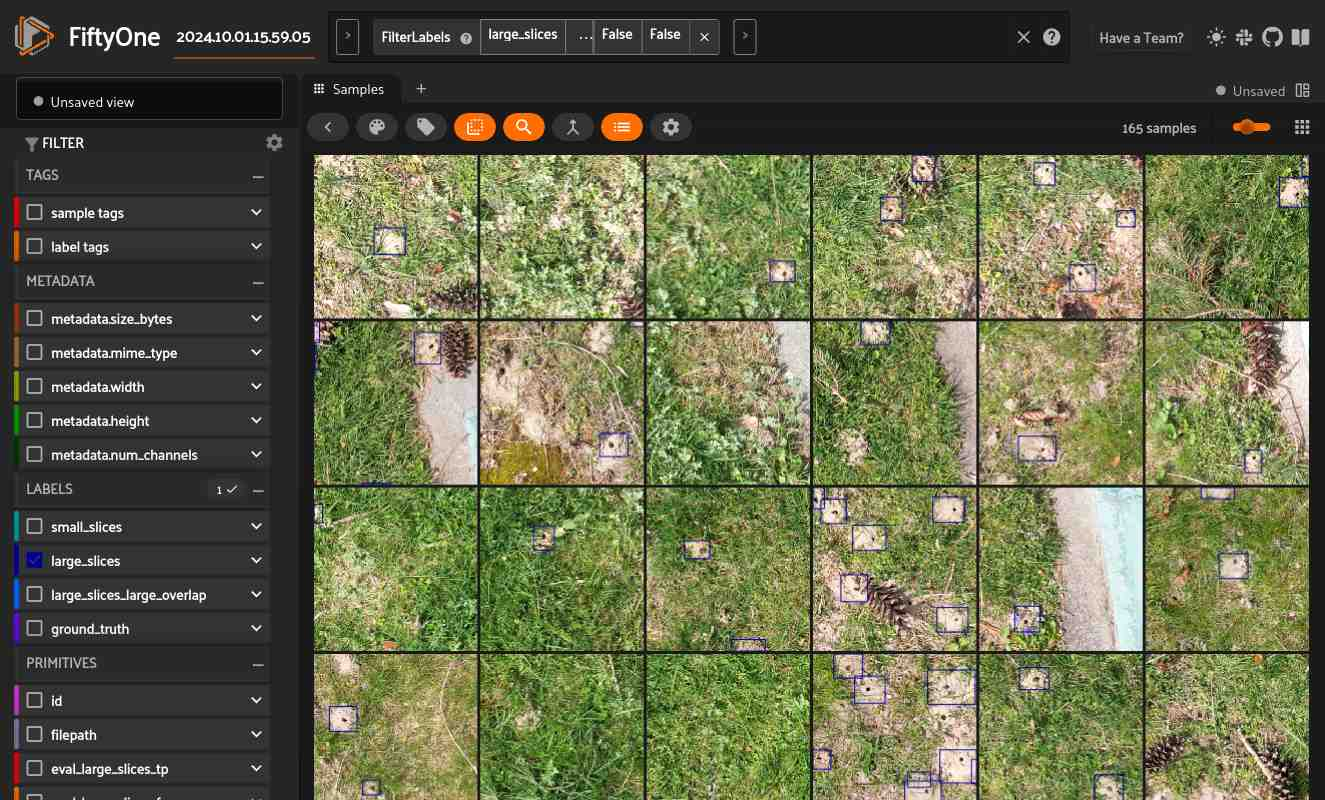

0.3028798798539592
              precision    recall  f1-score   support

        nest       0.71      0.69      0.70       239

   micro avg       0.71      0.69      0.70       239
   macro avg       0.71      0.69      0.70       239
weighted avg       0.71      0.69      0.70       239



In [124]:
# evaluate predictions



# evaluate the different sahi predictions
large_slice_results = datasettest.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = datasettest.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = datasettest.evaluate_detections("large_slices_large_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")


# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()




# then also evaluate just with confidence thresholding
from fiftyone import ViewField as F

high_conf_view = datasettest.filter_labels("large_slices", F("confidence") > 0.555, only_matches=False)

results = high_conf_view.evaluate_detections(
    "large_slices",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)


print(results.mAP())
results.print_report()




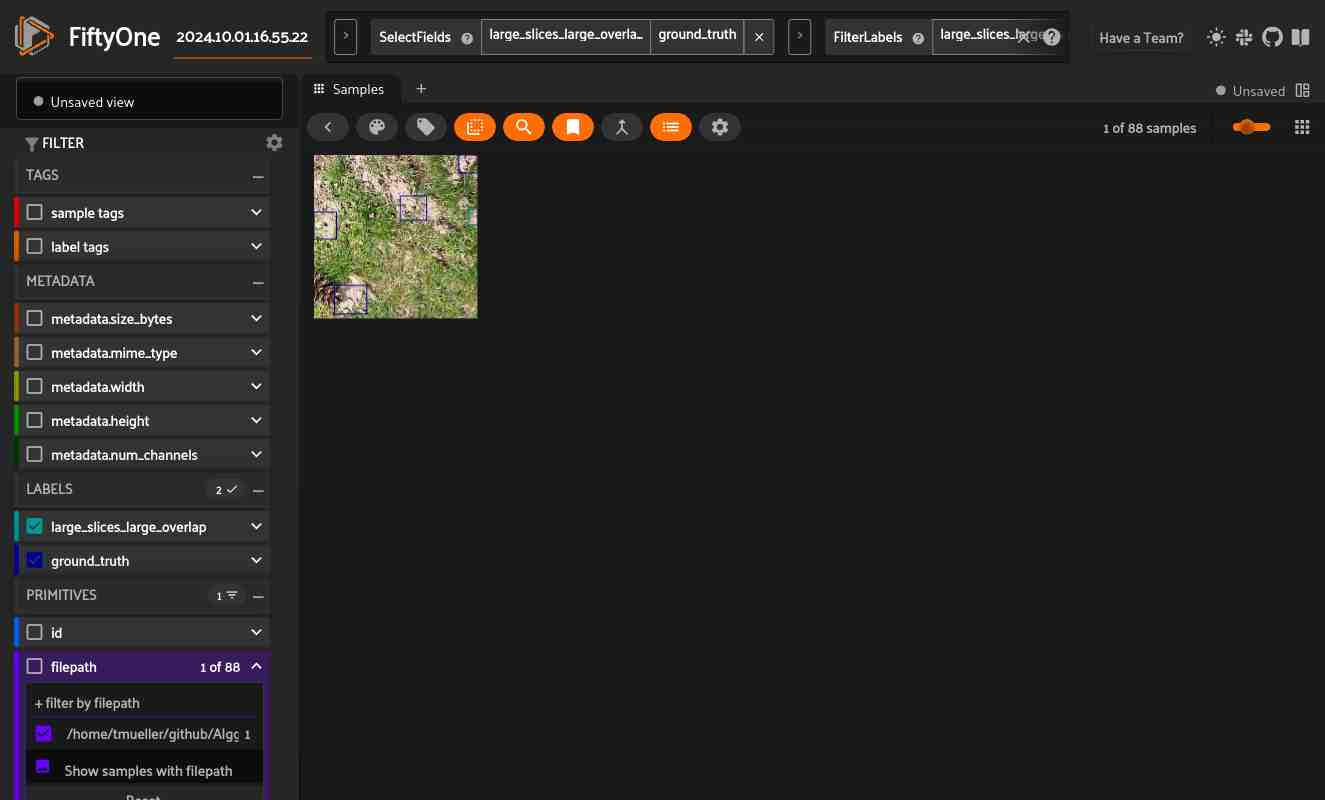

In [25]:

# now show images where sahi is labeling false positives
# check if ground_truth labels needs to be adjusted
# for instance in this very quickly annotated test image - AI is probably outperforming me to a degree...


high_conf_fp_view = datasettest.to_evaluation_patches(eval_key="eval_large_slices").match(F("type")=="fp").sort_by("large_slices.detection.confidence")

session.view = high_conf_fp_view.view()
